In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from nltk.tokenize import sent_tokenize
from nltk import word_tokenize
from tensorflow.keras import layers
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import numpy as np
import collections
import random
import json
import re

In [2]:
with open('ted_scraped.txt') as f:
    txt = f.readlines()

In [3]:
NEXT = 'NNNNN'
APPLAUSE = 'AAAAA'
LAUGHTER = 'LLLLL'

In [4]:
reactions = ["😐", "👏", "😂"]

In [5]:
def clean_raw_text(txt):
#     # Take out gratuitous newlines
#     txt = [line for line in txt if line != '\n']
#     txt = [(line[:-1] if '\n' in line[-1:] else line) for line in txt]
#     # Take out time stamps
#     txt = [line for line in txt if line[0] not in '0123456789']
    # Extra spaces at the end of lines, again
    txt = [line.strip() for line in txt]
    # Non-breaking spaces
    txt = [re.sub('\xa0', ' ', line) for line in txt]
    # Deal with stuff in parentheses
    txt = [(LAUGHTER if line == '(Laughter)' else line) for line in txt]
    txt = [(APPLAUSE if line == '(Applause)' else line) for line in txt]
    txt = [(APPLAUSE if line == '(Cheering)' else line) for line in txt]
    txt = [line for line in txt if (line[0] != '(' or line[-1] != ')')]
    # Remove enclosing [] for slides text
    txt = [(line[1:-1] if (line[0] == '[' and line[-1] == ']') else line) for line in txt]
    # Remove anything else in parentheses
    txt = [re.sub(r'\((.*?)\)', r'', line) for line in txt]
    # Extra spaces at the end of lines, again
    txt = [line.strip() for line in txt]
    return txt

def split_sentences(txt):
    new_txt = []
    for line in txt:
        sentences = sent_tokenize(line)
        new_txt += sentences
    return new_txt

In [6]:
cleaned = clean_raw_text(txt)
sentences = split_sentences(cleaned)

In [7]:
sentences

['NNNNN',
 'I danced with Bella for the first time as Bei Mir Bistu Shein filled the room.',
 'And her blue eyes locked with mine.',
 'We took turns singing and forgetting the words.',
 'She led, I followed.',
 'A waltz step here, a shimmy here.',
 'LLLLL',
 'Hands on our hearts, our foreheads touching, as we communicated through movement and music, making sense through nonsense.',
 'Bella is 83 and lives with dementia.',
 'The dance gives us a chance to find each other.',
 'How did I learn to dance with dementia?',
 "Because I'm not a dancer.",
 "And I'm not a doctor.",
 "But I've played one in the hospital.",
 "I'm a clown doctor.",
 'Or a medical clown.',
 'My tools are whoopee cushions, shakers',
 'and a red nose.',
 'You know the old adage "laughter is the best medicine?"',
 'I hear that a lot.',
 "Now, at the same time, there are studies to support it, but right now, I'd like to take you behind the nose and go beyond the laughter and share a few things that I've seen skating thro

In [8]:
vocab_size = 20000  # Only consider the top 20k words
maxlen = 200  # Only consider the first 200 words of each movie review

In [9]:
replace = {
    '...': '.', 
    '--': '.', 
    ':': ',', 
    ';': ',',
    '!': '.'
}

In [10]:
def clean_for_encoding(tokens):
    # Remove weird quotation marks
    tokens = [x for x in tokens if x not in ['``', "''"]]
    # Replace weird punctuation with normal punctuation
    tokens = [(replace[x] if x in replace else x) for x in tokens]
    return tokens

def get_encodings(text, vocab_size):
    # Tokenize
    tokens = word_tokenize(text.lower())
    tokens = clean_for_encoding(tokens)
    word_freqs = dict(collections.Counter(tokens))
    word_freqs_list = [(k, v) for k, v in word_freqs.items()]
    sorted_frequencies = sorted(word_freqs_list, key=lambda x: -x[1])
    abridged = sorted_frequencies[:vocab_size]
    index_to_word = [x[0] for x in abridged]
    word_to_index = {}
    for i, word in enumerate(index_to_word):
        word_to_index[word] = i
    return word_to_index, index_to_word

def encode_sentence(text, word_to_index):
    tokenized = word_tokenize(text.lower())
    tokenized = clean_for_encoding(tokenized)
    return [word_to_index[word] for word in tokenized if word in word_to_index]

def encode_sentences(sentences, word_to_index):
    return [encode_sentence(sentence, word_to_index) for sentence in sentences]

In [11]:
sentences_no_next = [s for s in sentences if s != NEXT]

In [12]:
word_to_index, index_to_word = get_encodings(' '.join(sentences_no_next), vocab_size=vocab_size)

In [13]:
word_to_index

{',': 0,
 '.': 1,
 'the': 2,
 'and': 3,
 'to': 4,
 'of': 5,
 'a': 6,
 'that': 7,
 'i': 8,
 'it': 9,
 'in': 10,
 'you': 11,
 'we': 12,
 'is': 13,
 "'s": 14,
 'this': 15,
 'so': 16,
 'was': 17,
 'they': 18,
 'for': 19,
 'but': 20,
 'are': 21,
 'with': 22,
 '?': 23,
 'what': 24,
 'do': 25,
 'have': 26,
 "n't": 27,
 'my': 28,
 'on': 29,
 'be': 30,
 'about': 31,
 'not': 32,
 'can': 33,
 'as': 34,
 'all': 35,
 'our': 36,
 'like': 37,
 'or': 38,
 'there': 39,
 'at': 40,
 'people': 41,
 "'re": 42,
 'when': 43,
 'if': 44,
 'me': 45,
 'one': 46,
 'just': 47,
 'an': 48,
 'from': 49,
 'because': 50,
 'your': 51,
 'lllll': 52,
 'how': 53,
 'them': 54,
 'he': 55,
 'now': 56,
 'their': 57,
 'these': 58,
 'by': 59,
 'had': 60,
 'know': 61,
 'us': 62,
 'who': 63,
 'more': 64,
 'would': 65,
 'out': 66,
 'up': 67,
 'were': 68,
 'really': 69,
 'get': 70,
 'going': 71,
 "'m": 72,
 'think': 73,
 'could': 74,
 'did': 75,
 'time': 76,
 'some': 77,
 'very': 78,
 'will': 79,
 'then': 80,
 'see': 81,
 'which': 8

In [14]:
special = [APPLAUSE, LAUGHTER]

def create_dataset(sentences, num_sentences=3):
    X = []
    y = []
    for i in range(len(sentences)):
        if sentences[i] in (special + [NEXT]):
            continue
        current_batch = encode_sentence(sentences[i], word_to_index)
        retrace_index = 0
        sentence_count = 1
        while sentence_count < num_sentences:
            retrace_index += 1
            index = i - retrace_index
            if index < 0 or sentences[index] == NEXT:
                break
            elif sentences[index] in special:
                continue
            current_batch = encode_sentence(sentences[index], word_to_index) + current_batch
            sentence_count += 1
        X.append(current_batch)
        if i < len(sentences) - 1 and sentences[i + 1] in special:
            y.append(special.index(sentences[i + 1]) + 1)
        else:
            y.append(0)
    return X, np.array(y)

In [54]:
X, y = create_dataset(sentences)

<AxesSubplot:ylabel='Count'>

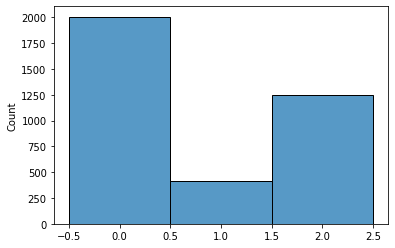

In [72]:
sns.histplot(y, discrete=True)

In [33]:
def downsample_zeros(X, y, rate=(1/6)):
    X_keep = []
    y_keep = []
    for i in range(len(X)):
        if not (y[i] == 0 and random.random() > rate):
            X_keep.append(X[i])
            y_keep.append(y[i])
    return X_keep, np.array(y_keep)

In [55]:
X, y = downsample_zeros(X, y, rate=(1/12))

In [56]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1)

In [37]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [38]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [73]:
embed_dim = 64  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(3, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [35]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
token_and_position_embedding (None, 200, 64)           1292800   
_________________________________________________________________
transformer_block (Transform (None, 200, 64)           37664     
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 20)                1300      
_________________________________________________________________
dropout_3 (Dropout)          (None, 20)                0     

In [74]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
X_val = keras.preprocessing.sequence.pad_sequences(X_val, maxlen=maxlen)

In [75]:
n_epochs = 3
weights = {0: 1, 1: 1, 2: 1}

model.compile("adam", "sparse_categorical_crossentropy", metrics=["accuracy"])
history = model.fit(
    X_train, y_train, batch_size=5, epochs=n_epochs, 
    validation_data=(X_val, y_val), 
    class_weight=weights,
    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)]
)

Epoch 1/3
661/661 [==============================] - 35s 51ms/step - loss: 0.9858 - accuracy: 0.5159 - val_loss: 0.9451 - val_accuracy: 0.5559
Epoch 2/3
661/661 [==============================] - 36s 54ms/step - loss: 0.8580 - accuracy: 0.5805 - val_loss: 0.7834 - val_accuracy: 0.6240
Epoch 3/3
661/661 [==============================] - 41s 62ms/step - loss: 0.5652 - accuracy: 0.7940 - val_loss: 0.8996 - val_accuracy: 0.5940


In [60]:
def plot_loss_history(history):
    loss_train = history.history['loss']
    loss_val = history.history['val_loss']
    epochs = range(0, len(loss_train))
    plt.plot(epochs, loss_train, 'g', label='Training loss')
    plt.plot(epochs, loss_val, 'b', label='validation loss')
    plt.title('Training and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

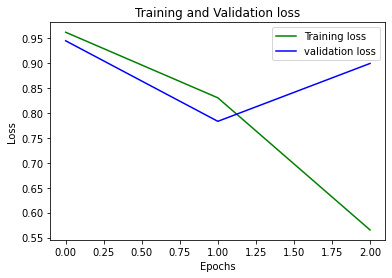

In [76]:
plot_loss_history(history)

In [77]:
predictions = model.predict(X_val)

In [78]:
y_pred = np.argmax(predictions, axis=-1)

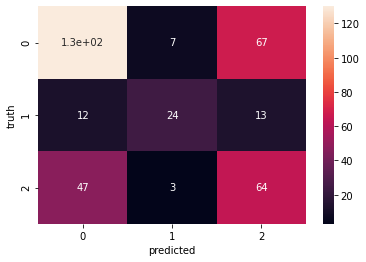

In [79]:
sns.heatmap(confusion_matrix(y_val, y_pred), annot=True)
plt.xlabel("predicted")
plt.ylabel("truth")
plt.show()

In [87]:
toy_text = [
    "NNNNN", 
    "I'd like to tell you about a call I got once as a school receptionist.", 
    "The person said, is this the school?", 
    "I said, no, this is Patrick.", 
    "You can imagine I didn't keep that job very long.",
    "On a more serious note, we need to talk about climate change. Our future generations will thank us for finally coming around to this planet-threatening issue.",
    "Thank you."]

In [88]:
toy_text

['NNNNN',
 "I'd like to tell you about a call I got once as a school receptionist.",
 'The person said, is this the school?',
 'I said, no, this is Patrick.',
 "You can imagine I didn't keep that job very long.",
 'On a more serious note, we need to talk about climate change. Our future generations will thank us for finally coming around to this planet-threatening issue.',
 'Thank you.']

In [89]:
toy_cleaned = clean_raw_text(toy_text)
toy_sentences = split_sentences(toy_cleaned)

In [90]:
toy_X, _ = create_dataset(toy_sentences)

In [91]:
toy_X = keras.preprocessing.sequence.pad_sequences(toy_X, maxlen=maxlen)

In [92]:
toy_pred = model.predict(toy_X)
toy_pred = np.argmax(toy_pred, axis=-1)

In [93]:
for i, sent in enumerate([s for s in toy_sentences if s != NEXT]):
    print(sent)
    print(f">> REACTION: {reactions[toy_pred[i]]}")

I'd like to tell you about a call I got once as a school receptionist.
>> REACTION: 😂
The person said, is this the school?
>> REACTION: 😂
I said, no, this is Patrick.
>> REACTION: 😂
You can imagine I didn't keep that job very long.
>> REACTION: 😂
On a more serious note, we need to talk about climate change.
>> REACTION: 😂
Our future generations will thank us for finally coming around to this planet-threatening issue.
>> REACTION: 👏
Thank you.
>> REACTION: 👏


In [51]:
model.save('transformer_4')

INFO:tensorflow:Assets written to: transformer_4/assets


INFO:tensorflow:Assets written to: transformer_4/assets


In [52]:
with open('word_to_index_4.json', 'w') as f:
    json.dump(word_to_index, f)